Systems
============

In this notebook we will examine a few examples of using functions in underworld. This is a continuation of the swarm particle and FE variable notebooks, so there is a certain amount of assumed knowledge about swarms and FE variables.

**This notebook is broken down into the following examples:**

1. Setting up boundary conditions
2. Steady state heat equation
3. Stokes systems
4. Swarm advection systems
5. Stokes system options (coming soon)

**Keywords:** underworld systems, Stokes system, advection system



In [1]:
%matplotlib inline
import matplotlib.pyplot as pyplot
import matplotlib.pylab as pylab
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt

Setting boundary conditions for the steady state heat equation
-----

In this example we will set up boundary conditions for the steady state heat equation given by
\\[
\nabla(k\nabla)T = h
\\]
where $k$ is the conductivity, T is the temperature field (solved for) and $h$ is any additional heating term. See also the tutorial **1_01_Steady_State_Heat.ipynb** for more details on the heat equation.

This user guide will focus more on how the boundary conditions are set in this system and the subsequent solve.

**Set up system**

Set simulation parameters

In [2]:
res = 64
dim = 2
boxLength = 1.0
boxHeight = 1.0

Create mesh and finite element variables

In [3]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))
temperatureField = uw.fevariable.FeVariable( feMesh=mesh, nodeDofCount=1 )

**Finding the boundary indices**

As discussed in **02_Meshing.ipynb** the mesh consists of a list of mesh nodes each with a distinct index and spatial coordinate. 

Here we will use a particle swarm to highlight the boundaries of the mesh.

In [4]:
# set a swarm where each particle sits on a mesh node
Swarm = uw.swarm.Swarm( feMesh=mesh )
SwarmCoords = mesh.data
Swarm.add_particles_with_coordinates(SwarmCoords)
# add an index variable to the swarm
swarmIndex = Swarm.add_variable( dataType="int", count=1 )

Look at special index sets - these contain the vertex numbers for along each boundary. 

Note that by convention, where the mesh has a resolution (I,J), we consider that I is the resolution is in the x direction and J is the resolution in the y direction. The vertices across the bottom of the domain are therefore contained within minimum 'J' set, and those across the top are in maximum 'J' set. 

In [5]:
mesh.specialSets.keys()

['MaxI_VertexSet',
 'MinI_VertexSet',
 'AllWalls',
 'AllWalls_VertexSet',
 'MinJ_VertexSet',
 'MaxJ_VertexSet',
 'Empty']

Highlight the bottom boundary by setting the swarm index in the special set "MinJ_VertexSet" to one, while the rest are set to zero. This same code can be used to look at the other boundaries listed in the special sets key above.

In [6]:
swarmIndex.data[:] = 0
for index in mesh.specialSets["MinJ_VertexSet"]:
    swarmIndex.data[index]=1

Visualise the highlighted swarm particles.

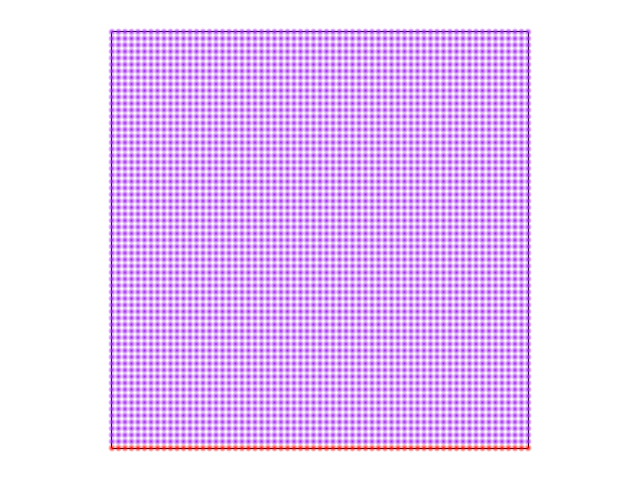

In [7]:
fig1 = plt.Figure()
fig1.Points( swarm=Swarm, colourVariable=swarmIndex, pointSize=8, colourBar = False)
fig1.show()

**Setting boundary conditions**

Now that we know how to obtain the indices for the boundaries we can use this approach to set the values for temperature along the boundary.

Firstly, set initial data for temperature

In [8]:
temperatureField.data[:] = 0.

Now set the temperature values along the top and bottom boundaries using the special sets of indices.

In [9]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = 1.0
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = 0.0

Plot the temperature field

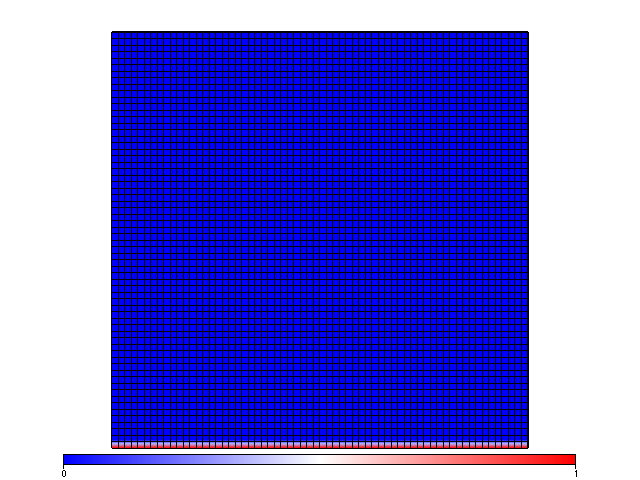

In [10]:
figtemp = plt.Figure()
figtemp.Surface(temperatureField, mesh, colours="blue white red")
figtemp.Mesh(mesh, colourBar = False)
figtemp.show()

**Flag boundaries as Dirichlet**

Using the special sets, we construct sets for the bottom and top walls which we will use to construct conditions on the system.

In [11]:
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

Underworld needs to know which vertices you wish to have fixed values on, i.e. which vertices should be flagged as conditions on the system. We are effectively telling the solver that for flagged vertices, the values are already known and it should not modify them (although it will certainly read and use them).

We use the DirechletCondition object to achieve this. This object will be passed into the solver below. For more information of Direchlet conditions see [here](https://en.wikipedia.org/wiki/Dirichlet_boundary_condition).

In [12]:
tempBC = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                           nodeIndexSets = (jWalls,) )

**Setup a heat equation solver**

Now the temperature field, a conductivity parameter and the boundary conditions are passed into a steady state heat equation system. This is then solved on the second line.

In [13]:
heatequation = uw.systems.SteadyStateHeat(temperatureField=temperatureField, conductivityFn=1.0, conditions=[tempBC,])
heatequation.solve()

Note that the conditions field has the temperature boundary conditions (``tempBC``) passed into it as a single field in a python tuple. Since this system consists of a temperature field only there is only a single value at each mesh point. For the velocity field this is more complicated (**see velocity example below**).

Below is the temperature field after solving the steady state heat equation.

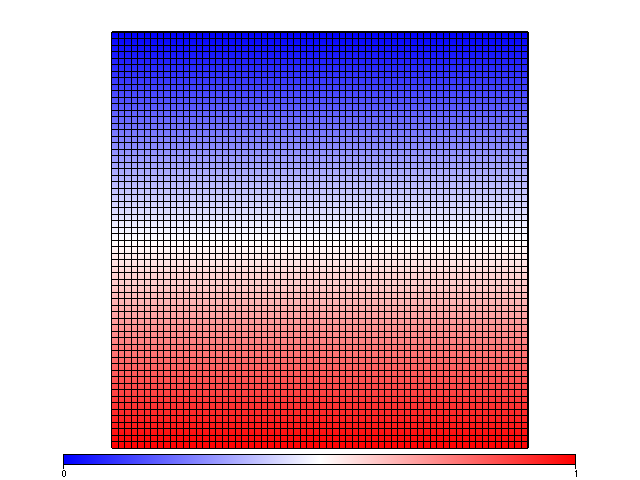

In [14]:
figtemp.show()

**Advanced "boundary" condition example**

Since the ``DirechletCondition`` is set by the index of the mesh we can play with this to hold any point of the temperature field constant - not just the boundary.

As an example let's set the wall boundaries to equal zero and fix the central temperature to be one.

In [15]:
# set T = 0 everywhere
temperatureField.data[:] = 0.
# get list of all vertices on the mesh boundary - these will be fixed as conditions below
allFixed = mesh.specialSets["AllWalls_VertexSet"]
# find the middle point in the mesh and set T=1 there
midindex = len(mesh.data)/2
temperatureField.data[midindex]=1.0
print('Mid index = {0:6d}; vertex position = ({1:.3f}, {2:.3f})'
      .format(midindex, mesh.data[midindex][0], mesh.data[midindex][1]))
# Add mesh point to index set "allFixed"
print('Number of vertices on boundary   = {0:6d}'.format(len(allFixed.data)))
allFixed.add(midindex)
print('Number of vertices to keep fixed = {0:6d}'.format(len(allFixed.data)))

Mid index =   2112; vertex position = (0.500, 0.500)
Number of vertices on boundary   =    256
Number of vertices to keep fixed =    257


Fix the temperatures on the special list of mesh vertices for all simulation time by flagging them as Dirichlet conditions. This list consists of all mesh points on the edge of the simulation box and a single mesh point in the centre of the box. 

In [16]:
tempBC = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                           nodeIndexSets = (allFixed) )

Solve the heat equation for $T = 0$ on the boundary and $T = 1$ in the centre. The commands below set up the system with conductivity set to one and the conditions set in the previous line.

In [17]:
# setup a steady state heat equation system
heatequation = uw.systems.SteadyStateHeat(temperatureField=temperatureField, conductivityFn=1.0, conditions=[tempBC,])
# solve the system
heatequation.solve()

Plot steady state solution for the temperature

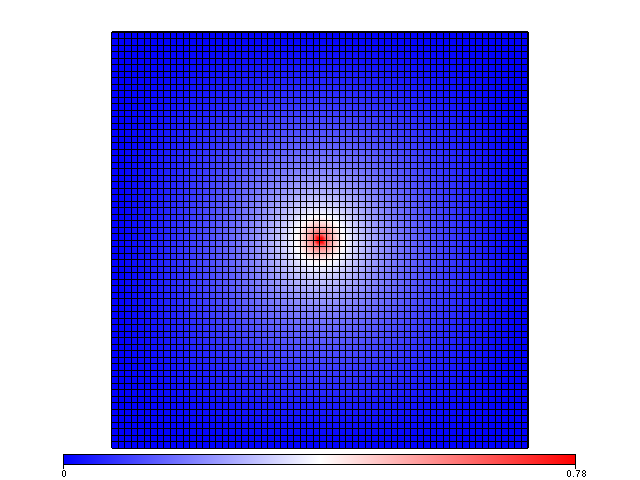

In [18]:
figtemp.show()

Stokes systems
-------


For most geodynamics problems the motion of the fluid is well described by [Stokes equations](https://en.wikipedia.org/wiki/Stokes_flow) which are a linearisation of the steady state Navier-Stokes Equations. Like the steady state heat equation, a Stokes system is solved at a given instant in time where the viscosity field and other forces are assumed constant. 

In underworld setting up such as system requires the velocity field, pressure, viscosity and buoyancy forces be passed to the Stokes system function. Along with the conditions affecting these variables - in this case the boundary conditions for the velocity field.

Geodynamical problems can then be handled by combining a Stokes system with an advection system. The advection systems moves the material around in response to the velocity field, which is calculated by solving the Stokes system. Once the material particles has been moved the density and viscosity fields are changed, since this information is attached to the swarm particles tracking the material movement. Since the density and viscosity are different a new solve of the Stokes system is done and the process begins again. By stepping this process forward in time complex systems are solved.

Setup the mesh and mesh variables.

In [19]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))
velocityField    = uw.fevariable.FeVariable( feMesh=mesh,         nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=mesh.subMesh, nodeDofCount=1 )
temperatureField = uw.fevariable.FeVariable( feMesh=mesh,         nodeDofCount=1 )

Setup some quick initial conditions.

In [20]:
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
for index, coord in enumerate(mesh.data):
    pertCoeff = math.cos( math.pi * coord[0]/boxLength ) * math.sin( math.pi * coord[1]/boxLength )
    temperatureField.data[index] = 1.0*(boxHeight - coord[1]) + 0.01 * pertCoeff
    temperatureField.data[index] = max(0.0, min(1.0, temperatureField.data[index]))

In [21]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

**Boundary conditions for velocity fields**

For two dimensional vector variables, we may flag up two Dirichlet conditions on each vertex.. for velocity it's a condition for $v_x$ and one for $v_y$. We provide a tuple of sets specifying which degrees of freedom (Set($v_x$), Set($v_y$)) should be considered Dirichlet. So the conditions below mean that the velocity components are fixed (at zero) in the horizontal direction for the side vertical walls, and fixed for the vertical components for the top and bottom walls. In other words no material can flow out of the simulation box.

As in the previous example, the temperature is held constant on the top and bottom boundaries via the tempBC object created below.

In [22]:
freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               nodeIndexSets = (iWalls, jWalls) )
tempBC     = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                               nodeIndexSets = (jWalls,) )

**Set up material parameters and functions**

Here quick functions for viscosity, density and buoyancy force are set.

In [23]:
# Set viscosity to be a constant.
viscosity = 1.
# Rayleigh number.
Ra = 1.0e4
# Construct our density function.
densityFn = -Ra * temperatureField
# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )
# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

In [24]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = [freeslipBC,],
                               viscosityFn   = viscosity, 
                               bodyForceFn   = buoyancyFn )

In [25]:
stokesPIC.solve()

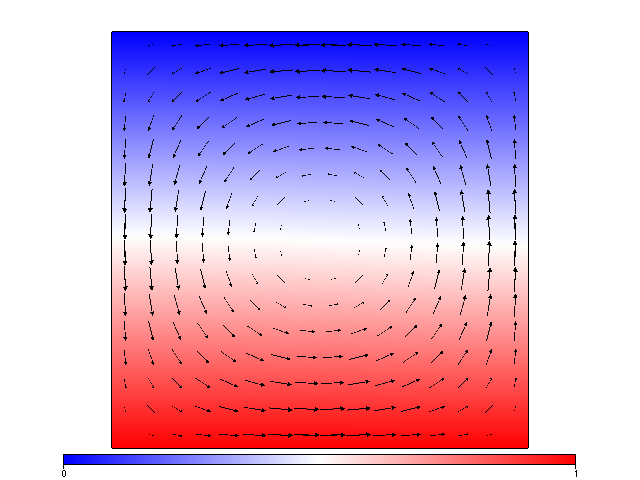

In [26]:
fig2 = plt.Figure()
velmagfield = uw.function.math.sqrt( uw.function.math.dot( velocityField, velocityField ) )
fig2.VectorArrows( velocityField/(4.0), mesh, arrowHead=0.2, scaling=0.1 )
fig2.Surface( temperatureField, mesh, colours="blue white red" )
fig2.show()

Advection system
-----

**Example 1: Tracer particles moving through constant velocity field**

Use the above example of a steady state velocity field solved using a Stokes system and show particles moving through it.

Velocity field has already been solved for and is stored in ``velocityField``. Next we create a particle swarm to add a single tracer particle to move in response to the velocity field.

In [27]:
# initialise a swarm. Note this must be the whole mesh, i.e. elementMesh.
swarm = uw.swarm.Swarm( feMesh=mesh )
# Setup an array containing the position data for the tracer
particleCoordinates = np.zeros((1,2))     # 1 is for the number of particles,
                                          # 2 for the number of dimensions for the position.
# Copy position data for the sphere into the newly created array
particleCoordinates[0] = (0.5, 0.9)
# Use this array to add particles to the swarm.
swarm.add_particles_with_coordinates(particleCoordinates)
print('Initial particle coordinates = ({0:.2f}, {1:.2f})'
      .format(swarm.particleCoordinates.data[0][0],swarm.particleCoordinates.data[0][1]))

Initial particle coordinates = (0.50, 0.90)


Plot the initial particle position superimposed with the velocity field.

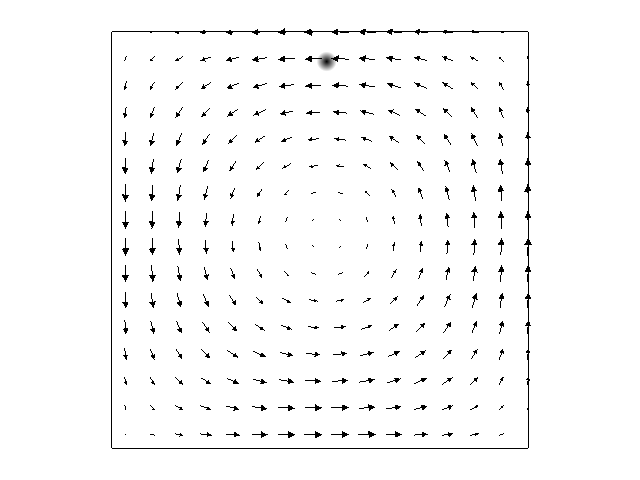

In [28]:
fig2 = plt.Figure()
fig2.VectorArrows( velocityField/(6.0), mesh, arrowHead=0.4, scaling=0.1 )
fig2.Points( swarm=swarm, pointSize=20, colourBar = False)
fig2.show()

**Setup an advection system**

The ``SwarmAdvector`` system takes the velocity field and advects the particles in the swarm in response to the velocity field.

In [29]:
advector  = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

Step the tracer particle forward in time by integrating the advection system forward by a single time step.

In [30]:
time = 0.
step = 0
steps_end = 10
while step < steps_end:
    # Retrieve the maximum possible timestep for the AD system.
    dt = advector.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advector.integrate(dt)
    print('t = {0:.3f}; x = {1:.3f}, y = {2:.3f}'
          .format(time,swarm.particleCoordinates.data[0][0],swarm.particleCoordinates.data[0][1]))
    step += 1
    time += dt

t = 0.000; x = 0.500, y = 0.900
t = 0.000; x = 0.493, y = 0.900
t = 0.003; x = 0.485, y = 0.900
t = 0.006; x = 0.478, y = 0.900
t = 0.009; x = 0.470, y = 0.900
t = 0.012; x = 0.463, y = 0.899
t = 0.015; x = 0.456, y = 0.899
t = 0.019; x = 0.448, y = 0.899
t = 0.022; x = 0.441, y = 0.898
t = 0.025; x = 0.434, y = 0.898


Plot final position of particle with the (constant) velocity field. As expected it has moved slightly in the direction of the velocity field at it's initial position. If the main loop is continued the particle will circulate around the simulation box.

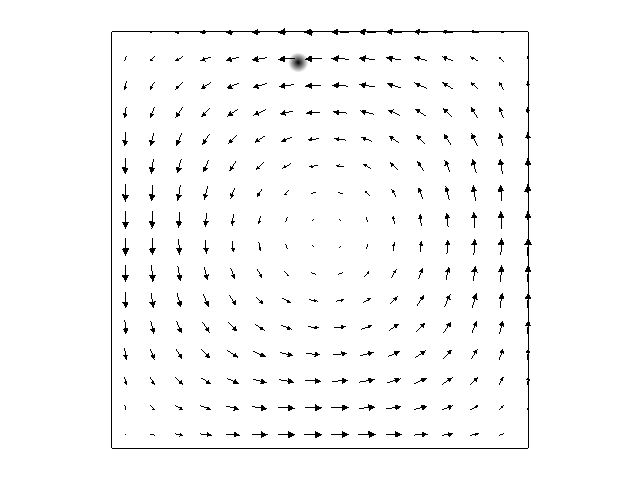

In [31]:
fig2.show()

**Example 2: Advection and Stokes systems**

Setup a bubble of low density fluid using particles and an advection system, which also needs a Stokes system each timestep to solve for the velocity field. *More details are given below; just before the main time loop*.


Setup new mesh and field variables

In [32]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))
velocityField = uw.fevariable.FeVariable( feMesh=mesh,         nodeDofCount=dim )
pressureField = uw.fevariable.FeVariable( feMesh=mesh.subMesh, nodeDofCount=1 )
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

Make a swarm over the entire region.

In [33]:
# Initialise a swarm.
swarm = uw.swarm.Swarm( feMesh=mesh )
# Add a data variable which will store an index to determine material.
materialVariable = swarm.add_variable( dataType="int", count=1 )
# Create a layout object that will populate the swarm across the whole domain.
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
# Populate.
swarm.populate_using_layout( layout=swarmLayout )

Add a circle shape at the bottom with a different material index. Obtain the index for the first swarm particle that is inside the circle, this will correspond with the bottom left most particle. This makes for a quick way to track the movement of bubble as it rises. 

In [34]:
circleRadius = 0.05
circleCentre = (0.5, 2.0*circleRadius)
topBubbleID = 0
for pID in range(len(swarm.particleCoordinates.data)):
    x = swarm.particleCoordinates.data[pID][0]
    z = swarm.particleCoordinates.data[pID][1]
    xx = x - circleCentre[0]
    zz = z - circleCentre[1]
    condition = (xx*xx + zz*zz < circleRadius**2)
    if(condition == True):  # inside the circle
        materialVariable.data[pID] = 1
        if(topBubbleID==0):
            topBubbleID = pID # will be the bottom, left most particle that is inside the circle (useful for tracking)
    else:
        materialVariable.data[pID] = 0
print('Tracer particle id = {0:6d}; Initial x = {1:.3f}, y = {2:.3f}'
      .format(topBubbleID,swarm.particleCoordinates.data[topBubbleID][0]
      ,swarm.particleCoordinates.data[topBubbleID][1]))

Tracer particle id =    102; Initial x = 0.508, y = 0.055


Plot initial conditions

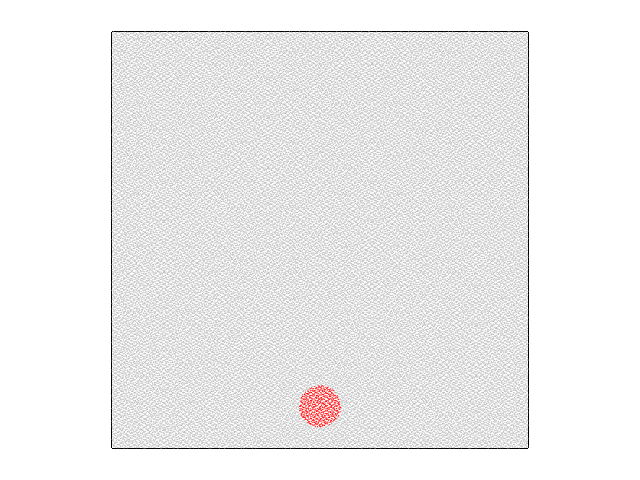

In [35]:
fig3 = plt.Figure()
fig3.Points( swarm=swarm, colourVariable=materialVariable, colours='grey red', colourBar = False, pointSize=2.0 )
fig3.show()

Set up the density, viscosity and buoyancy functions needed by the Stokes system. The density information in this example is carried by the swarm particles and is constructed using the branching function introduced in the user guide **05_Functions.ipynb**.

Viscosity information is also associated with a material and therefore carried by swarm particles. In this example the viscosity is held constant ($\nu = 1$) across all materials.

The buoyancy function depends on the local fluid density and the vertical direction (opposite direction to gravity). All of these functions are defined here before the main simulation time loop and will be used any time they are needed by the system solvers or plotting etc.

In [36]:
# Here we set a density of '0.' for the lightMaterial (bubble), and '1.' for the heavymaterial.
lightIndex = 1
denseIndex = 0
densityMap = { lightIndex:0., denseIndex:1. }
densityFn  = fn.branching.map( keyFunc = materialVariable, mappingDict = densityMap )

# Here we set a viscosity value of '1.' for both materials.
viscosityFn  = fn.misc.constant(1.0)

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )
# Now create a buoyancy force vector using the density (FEvariable) and the vertical unit vector. 
buoyancyFn = -densityFn*z_hat

**Set velocity boundary conditions**

As mentioned previously, setting the boundary conditions for the velocity field in a Stokes system is more complex than for the temperature field. This is because while the temperature field has a single degree of freedom (T) at each mesh vertex, the velocity field has as many degrees of freedom as there are spatial dimensions; i.e. ${\bf v} = (v_x, v_y)$ for 2D.

In the example below Dirichlet conditions are set on the velocity field such that $v_x$ is constant on ``allWalls`` and $v_y$ is constant only on ``jWalls``. In plain English the horizontal component of the velocity field is fixed to the initial conditions ($v_x = 0$) on all boundaries, while the vertical component is only fixed on the top and bottom boundaries ($v_y = 0$).

If we wanted $v_y = 0$ on all boundaries then the second term in the ``stokesBC`` second field should be replaced with ``allWalls``.

In [37]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
allWalls = iWalls + jWalls

# Now, using these sets, decide which degrees of freedom (on each node) should be considered Dirichlet.
stokesBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                             nodeIndexSets = (allWalls, jWalls) )
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               swarm         = swarm, 
                               conditions    = [stokesBC,],
                               viscosityFn   = viscosityFn, 
                               bodyForceFn   = buoyancyFn )

Setup the advection system to be dependent on the velocity field, as before.

In [38]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

Main simulation time loop.

In [39]:
time = 0.
time_end = 300.
step = 0
steps_end = 20
outputEvery = 5
while time < time_end:
    # Solve for the velocity field given the current temperature field.
    stokesPIC.solve()
    # Retrieve the maximum possible timestep for the AD system.
    dt = advector.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advector.integrate(dt)
    if step%outputEvery == 0:
        print('step = {0:3d}; t = {1:7.2f}; x = {2:.3f}, y = {3:.3f}'
              .format(step,time,swarm.particleCoordinates.data[topBubbleID][0]
              ,swarm.particleCoordinates.data[topBubbleID][1]))
    step += 1
    time += dt


step =   0; t =    0.00; x = 0.508, y = 0.055
step =   5; t =   47.09; x = 0.505, y = 0.077
step =  10; t =   96.15; x = 0.503, y = 0.102
step =  15; t =  138.86; x = 0.502, y = 0.128
step =  20; t =  177.48; x = 0.502, y = 0.155
step =  25; t =  213.42; x = 0.502, y = 0.183
step =  30; t =  247.57; x = 0.501, y = 0.209
step =  35; t =  280.37; x = 0.501, y = 0.235


Plot resulting bubble position and velocity field for the entire fluid.

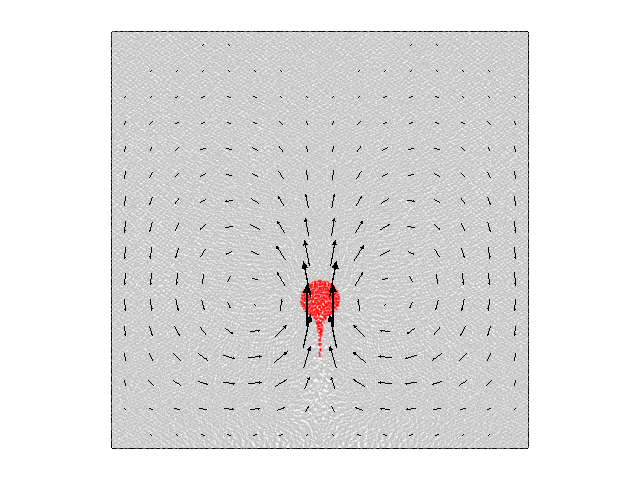

In [40]:
fig4 = plt.Figure()
fig4.VectorArrows( velocityField/(0.001), mesh, arrowHead=0.2, scaling=0.1 )
fig4.Points( swarm=swarm, colourVariable=materialVariable, colours='grey red', colourBar = False, pointSize=3.0 )
fig4.show()

More information
-----

This notebook has covered advection by the velocity field only, i.e. ``uw.systems.SwarmAdvector``. The other advector system type combines advection with diffusion (heat equation) using the command ``uw.systems.AdvectionDiffusion`` which requires the velocity and temperature fields to advect the particles. A simple example of such as system is given in the tutorial **1_02_Convection_Example.ipynb**.

For more information on the interaction between advection and Stokes systems the reader is directed to the tutorials directory, in particular **1_05_StokesSinker.ipynb** and **1_06_Rayleigh_Taylor.ipynb**.